In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


# jupyter nbconvert --to notebook --execute 23_Monte_Carlo_adaptability_2.ipynb --output=23_Monte_Carlo_adaptability_2_large.ipynb --ExecutePreprocessor.timeout=-1
np.random.seed(0)
jax.devices()

[cuda(id=0), cuda(id=1)]

In [3]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [4]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 1000
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 500

# MC parameters
total_steps = 20
total_samples = 5000
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [5]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [6]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, total_samples: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next[:n_chosen]
    
    def get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s:
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        i_while = 0
        while len(idxs_next) < choose_max:
            if len(adaptability) == 0:
                idxs_rnd = choose_next_rnd(choose_max - len(idxs_next), total_samples)
                idxs_next = jnp.concatenate([idxs_next, idxs_rnd])
            else:
                idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
            i_while += 1
            if i_while > 10:
                print('While loop was going forever...')
                break
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    if len(idxs_next) == 0:
        print('Not sure how this happened...')
        idxs_next = choose_next_rnd(choose_max - len(idxs_next), total_samples)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def choose_next_rnd(n_choose, total_samples):
    return jax.random.randint(jax.random.PRNGKey(0), (n_choose,), 0, total_samples)


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1} / {len(reverse_rates)}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1



Starting iteration 1 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  720  left to steady out.  0:00:43.102990


Done:  0:01:25.338630


Steady states:  500  iterations.  193  left to steady out.  0:00:41.508691


Done:  0:01:19.896211
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  831  left to steady out.  0:00:42.730657


Done:  0:01:26.726386


Steady states:  500  iterations.  250  left to steady out.  0:00:50.178768


Done:  0:01:32.397781
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  755  left to steady out.  0:00:42.312670


Done:  0:01:29.195788


Steady states:  500  iterations.  213  left to steady out.  0:00:40.827053


Done:  0:01:25.064726
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  808  left to steady out.  0:00:42.129678


Done:  0:01:24.451892


Steady states:  500  iterations.  211  left to steady out.  0:00:42.426093


Done:  0:01:22.460309
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  868  left to steady out.  0:00:40.845801


Done:  0:01:26.490580


Steady states:  500  iterations.  239  left to steady out.  0:00:39.433656


Done:  0:01:17.743401
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  728  left to steady out.  0:00:43.371751


Done:  0:01:27.510820


Steady states:  500  iterations.  238  left to steady out.  0:00:45.599305


Done:  0:01:29.031988
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  711  left to steady out.  0:00:44.189304


Done:  0:01:28.526580


Steady states:  500  iterations.  221  left to steady out.  0:00:43.484340


Done:  0:01:25.534816
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  739  left to steady out.  0:00:42.169389


Done:  0:01:23.791739


Steady states:  500  iterations.  205  left to steady out.  0:00:38.592380


Done:  0:01:22.535185
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  742  left to steady out.  0:00:42.037645


Done:  0:01:32.181761


Steady states:  500  iterations.  220  left to steady out.  0:00:53.172766


Done:  0:01:45.829949
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  689  left to steady out.  0:00:41.316473


Done:  0:01:27.980784


Steady states:  500  iterations.  221  left to steady out.  0:00:44.163825


Done:  0:01:28.808850


While loop was going forever...
Not sure how this happened...


Choosing 500 next circuits


Mutated and expanding 500 into 5000 next circuits


Starting iteration 2 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  786  left to steady out.  0:00:45.655615


Done:  0:01:39.242681


Steady states:  500  iterations.  221  left to steady out.  0:00:42.252844


Done:  0:01:26.508680
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  765  left to steady out.  0:00:44.082204


Done:  0:01:27.788193


Steady states:  500  iterations.  209  left to steady out.  0:00:43.642282


Done:  0:01:27.349464
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  808  left to steady out.  0:00:43.854032


Done:  0:01:29.307000


Steady states:  500  iterations.  236  left to steady out.  0:00:48.848066


Done:  0:01:34.330073
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  848  left to steady out.  0:00:47.967156


Done:  0:01:37.916924


Steady states:  500  iterations.  221  left to steady out.  0:00:43.239014


Done:  0:01:34.876445
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  825  left to steady out.  0:00:44.673253


Done:  0:01:29.748562


Steady states:  500  iterations.  219  left to steady out.  0:00:51.733770


Done:  0:01:39.347605
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  769  left to steady out.  0:00:51.319628


Done:  0:01:45.275385


Steady states:  500  iterations.  232  left to steady out.  0:00:40.723183


Done:  0:01:20.273799
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  770  left to steady out.  0:00:45.188008


Done:  0:01:33.395824


Steady states:  500  iterations.  212  left to steady out.  0:00:36.179909


Done:  0:01:21.956178
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  783  left to steady out.  0:00:45.856822


Done:  0:01:33.298477


Steady states:  500  iterations.  221  left to steady out.  0:00:43.095299


Done:  0:01:27.641657
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  792  left to steady out.  0:00:45.433550


Done:  0:01:33.503441


Steady states:  500  iterations.  219  left to steady out.  0:00:44.154276


Done:  0:01:24.519603
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  786  left to steady out.  0:00:45.979787


Done:  0:01:34.595266


Steady states:  500  iterations.  207  left to steady out.  0:00:41.423484


Done:  0:01:23.699433
While loop was going forever...
Not sure how this happened...
Choosing 500 next circuits


Mutated and expanding 500 into 5000 next circuits


Starting iteration 3 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  727  left to steady out.  0:00:44.602071


Done:  0:01:33.491789


Steady states:  500  iterations.  190  left to steady out.  0:00:38.281898


Done:  0:01:23.437011
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  798  left to steady out.  0:00:46.547550


Done:  0:01:35.462479


Steady states:  500  iterations.  210  left to steady out.  0:00:44.927013


Done:  0:01:33.831140
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  770  left to steady out.  0:00:47.692385


Done:  0:01:36.287508


Steady states:  500  iterations.  199  left to steady out.  0:00:51.922101


Done:  0:01:38.063735
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  779  left to steady out.  0:00:45.344857


Done:  0:01:28.755521


Steady states:  500  iterations.  220  left to steady out.  0:00:47.684833


Done:  0:01:35.855374
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  776  left to steady out.  0:00:43.648027


Done:  0:01:24.953653


Steady states:  500  iterations.  264  left to steady out.  0:00:45.453616


Done:  0:01:27.504177
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  802  left to steady out.  0:00:45.166159


Done:  0:01:29.553815


Steady states:  500  iterations.  219  left to steady out.  0:00:48.521592


Done:  0:01:42.241806
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  788  left to steady out.  0:00:45.134812


Done:  0:01:28.590562


Steady states:  500  iterations.  222  left to steady out.  0:00:46.711520


Done:  0:01:25.911812
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  785  left to steady out.  0:00:44.341582


Done:  0:01:32.254036


Steady states:  500  iterations.  221  left to steady out.  0:00:47.554120


Done:  0:01:28.529662
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  837  left to steady out.  0:00:47.669660


Done:  0:01:48.884424


Steady states:  500  iterations.  243  left to steady out.  0:00:41.729298


Done:  0:01:21.641420
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  750  left to steady out.  0:00:43.995670


Done:  0:01:25.043222


Steady states:  500  iterations.  221  left to steady out.  0:00:41.897139


Done:  0:01:34.737391


While loop was going forever...
Choosing 100 next circuits
Not enough circuits chosen, will randomly choose the rest


Mutated and expanding 500 into 5000 next circuits


Starting iteration 4 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  955  left to steady out.  0:00:44.898947


Done:  0:01:30.390844


Steady states:  500  iterations.  290  left to steady out.  0:00:42.617690


Done:  0:01:23.436380
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  920  left to steady out.  0:00:44.310639


Done:  0:01:33.097658


Steady states:  500  iterations.  276  left to steady out.  0:00:44.448706


Done:  0:01:27.046856
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  915  left to steady out.  0:00:45.789299


Done:  0:01:29.319412


Steady states:  500  iterations.  270  left to steady out.  0:00:51.012404


Done:  0:01:34.764280
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  903  left to steady out.  0:00:43.498125


Done:  0:01:30.638613


Steady states:  500  iterations.  242  left to steady out.  0:00:42.789943


Done:  0:01:24.683878
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  886  left to steady out.  0:00:44.328284


Done:  0:01:28.320572


Steady states:  500  iterations.  273  left to steady out.  0:00:47.991533


Done:  0:01:38.134504
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  943  left to steady out.  0:00:47.595059


Done:  0:01:32.292697


Steady states:  500  iterations.  254  left to steady out.  0:00:43.598706


Done:  0:01:29.487361
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  897  left to steady out.  0:00:45.331644


Done:  0:01:27.116516


Steady states:  500  iterations.  273  left to steady out.  0:00:44.224271


Done:  0:01:27.852118
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  929  left to steady out.  0:00:47.216566


Done:  0:01:28.552315


Steady states:  500  iterations.  237  left to steady out.  0:00:42.530090


Done:  0:01:32.216201
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  867  left to steady out.  0:00:45.439942


Done:  0:01:29.241097


Steady states:  500  iterations.  255  left to steady out.  0:00:43.004546


Done:  0:01:24.289183
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  883  left to steady out.  0:00:44.610581


Done:  0:01:33.092241


Steady states:  500  iterations.  247  left to steady out.  0:00:40.289526


Done:  0:01:26.988558
While loop was going forever...
Choosing 100 next circuits
Not enough circuits chosen, will randomly choose the rest
Mutated and expanding 500 into 5000 next circuits


Starting iteration 5 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  1004  left to steady out.  0:00:43.186419


Done:  0:01:32.965648


Steady states:  500  iterations.  258  left to steady out.  0:00:42.610772


Done:  0:01:24.597894
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  992  left to steady out.  0:00:43.739000


Done:  0:01:29.370146


Steady states:  500  iterations.  254  left to steady out.  0:00:41.392879


Done:  0:01:32.509430
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  996  left to steady out.  0:00:42.516643


Done:  0:01:29.029567


Steady states:  500  iterations.  262  left to steady out.  0:00:42.345427


Done:  0:01:22.999441
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  1037  left to steady out.  0:00:42.012804


Done:  0:01:28.047468


Steady states:  500  iterations.  287  left to steady out.  0:00:42.480842


Done:  0:01:24.059161
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  974  left to steady out.  0:00:43.321103


Done:  0:01:25.960212


Steady states:  500  iterations.  260  left to steady out.  0:00:46.755265


Done:  0:01:31.779525
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  1001  left to steady out.  0:00:40.753161


Done:  0:01:28.520236


Steady states:  500  iterations.  284  left to steady out.  0:00:47.222165


Done:  0:01:33.529101
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  996  left to steady out.  0:00:41.179383


Done:  0:01:18.386169


Steady states:  500  iterations.  296  left to steady out.  0:00:39.688073


Done:  0:01:18.272776
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  1023  left to steady out.  0:00:44.313719


Done:  0:01:36.501714


Steady states:  500  iterations.  278  left to steady out.  0:00:52.003667


Done:  0:01:35.861731
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  1017  left to steady out.  0:00:41.279382


Done:  0:01:19.270676


Steady states:  500  iterations.  259  left to steady out.  0:00:52.846114


Done:  0:01:40.336787
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  986  left to steady out.  0:00:41.078283


Done:  0:01:25.528455


Steady states:  500  iterations.  284  left to steady out.  0:00:47.040903


Done:  0:01:31.866414


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 6 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  1321  left to steady out.  0:00:42.894803


Done:  0:01:21.471879


Steady states:  500  iterations.  357  left to steady out.  0:00:41.911903


Done:  0:01:24.004977
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  1334  left to steady out.  0:00:44.024901


Done:  0:01:24.009229


Steady states:  500  iterations.  293  left to steady out.  0:00:42.438845


Done:  0:01:25.609913
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  1289  left to steady out.  0:00:43.946111


Done:  0:01:22.834919


Steady states:  500  iterations.  316  left to steady out.  0:00:40.826685


Done:  0:01:25.550212
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  1323  left to steady out.  0:00:43.486342


Done:  0:01:26.053215


Steady states:  500  iterations.  314  left to steady out.  0:00:43.918949


Done:  0:01:32.135709
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  1314  left to steady out.  0:00:40.983998


Done:  0:01:20.437912


Steady states:  500  iterations.  291  left to steady out.  0:00:42.998335


Done:  0:01:25.315347
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  1295  left to steady out.  0:00:39.007312


Done:  0:01:16.690868


Steady states:  500  iterations.  276  left to steady out.  0:00:41.474719


Done:  0:01:28.291235
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  1336  left to steady out.  0:00:40.302875


Done:  0:01:21.445611


Steady states:  500  iterations.  315  left to steady out.  0:00:41.992820


Done:  0:01:23.063230
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  1379  left to steady out.  0:00:40.417056


Done:  0:01:19.135046


Steady states:  500  iterations.  323  left to steady out.  0:00:45.982445


Done:  0:01:31.740784
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  1304  left to steady out.  0:00:39.395294


Done:  0:01:18.958302


Steady states:  500  iterations.  269  left to steady out.  0:00:42.107193


Done:  0:01:24.010544
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  1301  left to steady out.  0:00:44.536285


Done:  0:01:23.619582


Steady states:  500  iterations.  313  left to steady out.  0:00:41.092983


Done:  0:01:22.566383
Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 7 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  983  left to steady out.  0:00:43.989327


Done:  0:01:26.995775


Steady states:  500  iterations.  212  left to steady out.  0:00:35.503445


Done:  0:01:08.148536
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  968  left to steady out.  0:00:42.143587


Done:  0:01:27.219716


Steady states:  500  iterations.  207  left to steady out.  0:00:40.159934


Done:  0:01:21.105124
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  895  left to steady out.  0:00:44.492090


Done:  0:01:28.481710


Steady states:  500  iterations.  182  left to steady out.  0:00:41.247461


Done:  0:01:17.432569
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  918  left to steady out.  0:00:42.019945


Done:  0:01:23.142617


Steady states:  500  iterations.  180  left to steady out.  0:00:37.772351


Done:  0:01:15.040648
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  980  left to steady out.  0:00:43.467954


Done:  0:01:25.286226


Steady states:  500  iterations.  176  left to steady out.  0:00:43.807122


Done:  0:01:26.914691
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  959  left to steady out.  0:00:44.365268


Done:  0:01:23.898427


Steady states:  500  iterations.  203  left to steady out.  0:00:41.194115


Done:  0:01:19.995972
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  959  left to steady out.  0:00:44.190351


Done:  0:01:30.460833


Steady states:  500  iterations.  200  left to steady out.  0:00:38.391062


Done:  0:01:17.036481
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  895  left to steady out.  0:00:42.741267


Done:  0:01:28.671175


Steady states:  500  iterations.  226  left to steady out.  0:00:43.102894


Done:  0:01:27.781916
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  928  left to steady out.  0:00:44.349247


Done:  0:01:26.549990


Steady states:  500  iterations.  213  left to steady out.  0:00:45.149362


Done:  0:01:29.691040
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  891  left to steady out.  0:00:43.652215


Done:  0:01:19.394512


Steady states:  500  iterations.  212  left to steady out.  0:00:42.321324


Done:  0:01:18.652113
Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 8 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  959  left to steady out.  0:00:43.565194


Done:  0:01:29.669718


Steady states:  500  iterations.  196  left to steady out.  0:00:45.172176


Done:  0:01:25.859939
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  888  left to steady out.  0:00:45.509636


Done:  0:01:28.686660


Steady states:  500  iterations.  223  left to steady out.  0:00:43.411714


Done:  0:01:22.383565
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  951  left to steady out.  0:00:43.688904


Done:  0:01:24.647085


Steady states:  500  iterations.  246  left to steady out.  0:00:36.142517


Done:  0:01:22.979113
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  966  left to steady out.  0:00:44.738191


Done:  0:01:31.213733


Steady states:  500  iterations.  163  left to steady out.  0:00:44.271792


Done:  0:01:25.430675
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  873  left to steady out.  0:00:43.862070


Done:  0:01:27.046353


Steady states:  500  iterations.  203  left to steady out.  0:00:43.664548


Done:  0:01:28.321192
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  982  left to steady out.  0:00:45.502596


Done:  0:01:30.764628


Steady states:  500  iterations.  199  left to steady out.  0:00:47.534603


Done:  0:01:29.779671
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  974  left to steady out.  0:00:44.815971


Done:  0:01:22.729040


Steady states:  500  iterations.  213  left to steady out.  0:00:46.191764


Done:  0:01:34.833401
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  960  left to steady out.  0:00:42.155540


Done:  0:01:26.272178


Steady states:  500  iterations.  234  left to steady out.  0:00:43.494820


Done:  0:01:28.977318
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  946  left to steady out.  0:00:43.353046


Done:  0:01:26.454568


Steady states:  500  iterations.  225  left to steady out.  0:00:40.595612


Done:  0:01:19.352795
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  977  left to steady out.  0:00:45.156760


Done:  0:01:21.598222


Steady states:  500  iterations.  240  left to steady out.  0:00:44.576286


Done:  0:01:28.193972
Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 9 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  983  left to steady out.  0:00:37.215463


Done:  0:01:18.336954


Steady states:  500  iterations.  230  left to steady out.  0:00:38.357415


Done:  0:01:17.279839
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  980  left to steady out.  0:00:37.261373


Done:  0:01:13.300092


Steady states:  500  iterations.  263  left to steady out.  0:00:36.843882


Done:  0:01:12.694447
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  952  left to steady out.  0:00:38.212820


Done:  0:01:15.915538


Steady states:  500  iterations.  230  left to steady out.  0:00:40.189621


Done:  0:01:24.525405
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  977  left to steady out.  0:00:38.934875


Done:  0:01:17.051139


Steady states:  500  iterations.  253  left to steady out.  0:00:38.936989


Done:  0:01:15.192841
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  954  left to steady out.  0:00:37.896149


Done:  0:01:14.319801


Steady states:  500  iterations.  239  left to steady out.  0:00:36.860315


Done:  0:01:15.772167
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  1004  left to steady out.  0:00:36.579768


Done:  0:01:13.993085


Steady states:  500  iterations.  264  left to steady out.  0:00:37.463671


Done:  0:01:13.467688
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  996  left to steady out.  0:00:37.357613


Done:  0:01:14.766335


Steady states:  500  iterations.  262  left to steady out.  0:00:36.607109


Done:  0:01:21.408632
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  968  left to steady out.  0:00:37.393196


Done:  0:01:14.131527


Steady states:  500  iterations.  236  left to steady out.  0:00:39.469594


Done:  0:01:24.580204
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  976  left to steady out.  0:00:37.389080


Done:  0:01:15.212182


Steady states:  500  iterations.  216  left to steady out.  0:00:40.939676


Done:  0:01:21.532093
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  958  left to steady out.  0:00:37.804321


Done:  0:01:15.177195


Steady states:  500  iterations.  248  left to steady out.  0:00:37.672534


Done:  0:01:15.873182


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 10 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  735  left to steady out.  0:00:36.845074


Done:  0:01:13.306424


Steady states:  500  iterations.  167  left to steady out.  0:00:37.026800


Done:  0:01:11.430028
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  737  left to steady out.  0:00:37.500967


Done:  0:01:15.003151


Steady states:  500  iterations.  166  left to steady out.  0:00:38.107793


Done:  0:01:16.991090
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  735  left to steady out.  0:00:36.403202


Done:  0:01:12.959819


Steady states:  500  iterations.  152  left to steady out.  0:00:36.955722


Done:  0:01:13.171304
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  798  left to steady out.  0:00:37.858243


Done:  0:01:14.290520


Steady states:  500  iterations.  154  left to steady out.  0:00:35.666004


Done:  0:01:11.526159
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  768  left to steady out.  0:00:36.309677


Done:  0:01:13.057289


Steady states:  500  iterations.  161  left to steady out.  0:00:35.620920


Done:  0:01:10.368320
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  734  left to steady out.  0:00:36.578170


Done:  0:01:13.869990


Steady states:  500  iterations.  153  left to steady out.  0:00:35.386057


Done:  0:01:12.870263
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  736  left to steady out.  0:00:35.953478


Done:  0:01:11.023551


Steady states:  500  iterations.  203  left to steady out.  0:00:36.298271


Done:  0:01:20.366334
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  763  left to steady out.  0:00:37.338632


Done:  0:01:18.762140


Steady states:  500  iterations.  173  left to steady out.  0:00:36.251695


Done:  0:01:12.608697
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  783  left to steady out.  0:00:35.932322


Done:  0:01:12.496074


Steady states:  500  iterations.  175  left to steady out.  0:00:36.123949


Done:  0:01:12.253500
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  764  left to steady out.  0:00:37.468270


Done:  0:01:15.064311


Steady states:  500  iterations.  190  left to steady out.  0:00:36.804294


Done:  0:01:19.734998


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 11 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  498  left to steady out.  0:00:35.746068


Done:  0:01:10.886057


Steady states:  500  iterations.  64  left to steady out.  0:00:34.261721


Done:  0:01:09.573339
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  531  left to steady out.  0:00:35.515106


Done:  0:01:10.827569


Steady states:  500  iterations.  59  left to steady out.  0:00:34.155644


Done:  0:01:07.309490
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  511  left to steady out.  0:00:35.521202


Done:  0:01:10.456577


Steady states:  500  iterations.  88  left to steady out.  0:00:36.571459


Done:  0:01:12.363435
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  559  left to steady out.  0:00:35.770088


Done:  0:01:11.004341


Steady states:  500  iterations.  74  left to steady out.  0:00:34.613202


Done:  0:01:19.208019
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  529  left to steady out.  0:00:36.447558


Done:  0:01:11.712940


Steady states:  500  iterations.  89  left to steady out.  0:00:35.046100


Done:  0:01:08.536398
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  503  left to steady out.  0:00:34.847351


Done:  0:01:09.483331


Steady states:  500  iterations.  83  left to steady out.  0:00:34.652537


Done:  0:01:08.447081
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  520  left to steady out.  0:00:36.335998


Done:  0:01:12.759588


Steady states:  500  iterations.  64  left to steady out.  0:00:36.072625


Done:  0:01:17.464280
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  482  left to steady out.  0:00:35.840961


Done:  0:01:11.935524


Steady states:  500  iterations.  78  left to steady out.  0:00:36.273731


Done:  0:01:11.162744
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  525  left to steady out.  0:00:35.530812


Done:  0:01:11.021424


Steady states:  500  iterations.  81  left to steady out.  0:00:37.241606


Done:  0:01:19.154207
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  510  left to steady out.  0:00:33.609348


Done:  0:01:07.271473


Steady states:  500  iterations.  63  left to steady out.  0:00:35.829130


Done:  0:01:13.852803


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 12 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  405  left to steady out.  0:00:29.026227


Done:  0:01:02.564058


Steady states:  500  iterations.  61  left to steady out.  0:00:26.447726


Done:  0:01:00.857949
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  416  left to steady out.  0:00:28.937798


Done:  0:00:59.803007


Steady states:  500  iterations.  67  left to steady out.  0:00:32.043330


Done:  0:01:05.663274
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  413  left to steady out.  0:00:28.814664


Done:  0:00:59.537774


Steady states:  500  iterations.  63  left to steady out.  0:00:28.836415


Done:  0:00:56.222067
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  458  left to steady out.  0:00:28.993241


Done:  0:01:00.684672


Steady states:  500  iterations.  67  left to steady out.  0:00:29.666953


Done:  0:01:01.425990
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  422  left to steady out.  0:00:27.527939


Done:  0:00:58.238092


Steady states:  500  iterations.  52  left to steady out.  0:00:31.189484


Done:  0:01:02.526394
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  440  left to steady out.  0:00:31.251700


Done:  0:01:01.675623


Steady states:  500  iterations.  73  left to steady out.  0:00:32.094336


Done:  0:01:02.892967
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  385  left to steady out.  0:00:29.985224


Done:  0:00:59.306892


Steady states:  500  iterations.  51  left to steady out.  0:00:30.705775


Done:  0:01:04.388474
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  432  left to steady out.  0:00:27.503344


Done:  0:01:03.523447


Steady states:  500  iterations.  63  left to steady out.  0:00:33.050399


Done:  0:01:03.996830
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  442  left to steady out.  0:00:29.203585


Done:  0:01:02.167055


Steady states:  500  iterations.  54  left to steady out.  0:00:33.436138


Done:  0:01:05.103231
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  410  left to steady out.  0:00:27.612429


Done:  0:00:57.131666


Steady states:  500  iterations.  58  left to steady out.  0:00:28.735526


Done:  0:00:56.859708


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 13 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  407  left to steady out.  0:00:29.359216


Done:  0:01:01.248480


Steady states:  500  iterations.  60  left to steady out.  0:00:34.479194


Done:  0:01:07.437518
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  423  left to steady out.  0:00:29.336194


Done:  0:01:01.257277


Steady states:  500  iterations.  55  left to steady out.  0:00:31.952908


Done:  0:01:03.766988
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  417  left to steady out.  0:00:30.201608


Done:  0:01:02.929586


Steady states:  500  iterations.  48  left to steady out.  0:00:31.069182


Done:  0:01:04.172818
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  428  left to steady out.  0:00:32.110506


Done:  0:01:06.750599


Steady states:  500  iterations.  57  left to steady out.  0:00:32.356290


Done:  0:01:04.490891
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  375  left to steady out.  0:00:31.258765


Done:  0:01:04.192716


Steady states:  500  iterations.  68  left to steady out.  0:00:29.802508


Done:  0:01:03.146096
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  402  left to steady out.  0:00:31.199174


Done:  0:01:03.698189


Steady states:  500  iterations.  63  left to steady out.  0:00:29.952769


Done:  0:01:02.834989
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  430  left to steady out.  0:00:31.485424


Done:  0:01:05.165392


Steady states:  500  iterations.  51  left to steady out.  0:00:31.314619


Done:  0:01:03.567531
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  390  left to steady out.  0:00:29.600152


Done:  0:01:02.319123


Steady states:  500  iterations.  52  left to steady out.  0:00:30.717081


Done:  0:01:01.488698
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  405  left to steady out.  0:00:28.349183


Done:  0:00:56.867113


Steady states:  500  iterations.  59  left to steady out.  0:00:37.131751


Done:  0:01:10.907382
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  435  left to steady out.  0:00:30.653395


Done:  0:01:01.814686


Steady states:  500  iterations.  66  left to steady out.  0:00:28.953915


Done:  0:01:02.133354


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 14 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  355  left to steady out.  0:00:29.954287


Done:  0:01:01.150643


Steady states:  500  iterations.  57  left to steady out.  0:00:31.489239


Done:  0:01:04.512365
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  377  left to steady out.  0:00:30.072494


Done:  0:01:03.077782


Steady states:  500  iterations.  60  left to steady out.  0:00:31.098351


Done:  0:01:05.137115
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  405  left to steady out.  0:00:30.908705


Done:  0:01:03.055545


Steady states:  500  iterations.  58  left to steady out.  0:00:29.857240


Done:  0:01:04.074593
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  380  left to steady out.  0:00:29.852095


Done:  0:01:04.046181


Steady states:  500  iterations.  47  left to steady out.  0:00:32.953948


Done:  0:01:07.652796
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  359  left to steady out.  0:00:32.457666


Done:  0:01:06.015881


Steady states:  500  iterations.  43  left to steady out.  0:00:30.785857


Done:  0:01:04.395704
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  392  left to steady out.  0:00:30.602179


Done:  0:01:01.007413


Steady states:  500  iterations.  61  left to steady out.  0:00:39.786386


Done:  0:01:11.903253
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  371  left to steady out.  0:00:30.653412


Done:  0:01:04.816047


Steady states:  500  iterations.  63  left to steady out.  0:00:32.968801


Done:  0:01:05.546939
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  363  left to steady out.  0:00:30.694801


Done:  0:01:03.104862


Steady states:  500  iterations.  74  left to steady out.  0:00:29.658842


Done:  0:01:02.451486
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  371  left to steady out.  0:00:30.854782


Done:  0:01:03.241196


Steady states:  500  iterations.  62  left to steady out.  0:00:33.124622


Done:  0:01:06.563387
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  350  left to steady out.  0:00:30.193472


Done:  0:01:03.278267


Steady states:  500  iterations.  69  left to steady out.  0:00:30.012993


Done:  0:01:04.641407


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 15 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  343  left to steady out.  0:00:32.802300


Done:  0:01:18.225616


Steady states:  500  iterations.  54  left to steady out.  0:00:40.704266


Done:  0:01:21.363427
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  338  left to steady out.  0:00:31.809379


Done:  0:01:05.509724


Steady states:  500  iterations.  51  left to steady out.  0:00:34.038978


Done:  0:01:08.224733
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  344  left to steady out.  0:00:29.744271


Done:  0:01:04.035050


Steady states:  500  iterations.  38  left to steady out.  0:00:31.447988


Done:  0:01:06.273187
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  317  left to steady out.  0:00:31.717198


Done:  0:01:04.619218


Steady states:  500  iterations.  53  left to steady out.  0:00:33.137156


Done:  0:01:05.957113
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  348  left to steady out.  0:00:30.432881


Done:  0:01:04.401337


Steady states:  500  iterations.  54  left to steady out.  0:00:30.503249


Done:  0:01:04.551909
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  371  left to steady out.  0:00:32.184009


Done:  0:01:04.963170


Steady states:  500  iterations.  72  left to steady out.  0:00:32.388645


Done:  0:01:05.664631
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  368  left to steady out.  0:00:30.505643


Done:  0:01:03.359028


Steady states:  500  iterations.  47  left to steady out.  0:00:32.098531


Done:  0:01:05.891077
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  331  left to steady out.  0:00:32.980826


Done:  0:01:06.368008


Steady states:  500  iterations.  47  left to steady out.  0:00:32.243405


Done:  0:01:05.628670
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  334  left to steady out.  0:00:30.300705


Done:  0:01:07.878771


Steady states:  500  iterations.  53  left to steady out.  0:00:33.553374


Done:  0:01:08.196433
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  344  left to steady out.  0:00:31.168926


Done:  0:01:02.496182


Steady states:  500  iterations.  43  left to steady out.  0:00:33.316295


Done:  0:01:06.076820


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 16 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  344  left to steady out.  0:00:30.577118


Done:  0:01:04.417921


Steady states:  500  iterations.  50  left to steady out.  0:00:32.109420


Done:  0:01:04.229391
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  283  left to steady out.  0:00:30.292634


Done:  0:01:04.550634


Steady states:  500  iterations.  51  left to steady out.  0:00:34.852893


Done:  0:01:07.063100
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  356  left to steady out.  0:00:31.623811


Done:  0:01:04.952494


Steady states:  500  iterations.  46  left to steady out.  0:00:33.603646


Done:  0:01:06.604228
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  321  left to steady out.  0:00:31.608981


Done:  0:01:13.185825


Steady states:  500  iterations.  53  left to steady out.  0:00:34.301056


Done:  0:01:09.081113
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  312  left to steady out.  0:00:31.468175


Done:  0:01:05.226152


Steady states:  500  iterations.  54  left to steady out.  0:00:33.084024


Done:  0:01:06.661963
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  334  left to steady out.  0:00:31.679680


Done:  0:01:05.242293


Steady states:  500  iterations.  56  left to steady out.  0:00:32.828943


Done:  0:01:05.803258
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  369  left to steady out.  0:00:31.973712


Done:  0:01:04.224601


Steady states:  500  iterations.  49  left to steady out.  0:00:32.598368


Done:  0:01:06.177542
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  346  left to steady out.  0:00:29.848720


Done:  0:01:03.423451


Steady states:  500  iterations.  58  left to steady out.  0:00:34.047954


Done:  0:01:14.407804
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  355  left to steady out.  0:00:31.911082


Done:  0:01:05.803717


Steady states:  500  iterations.  54  left to steady out.  0:00:32.905303


Done:  0:01:06.601429
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  353  left to steady out.  0:00:31.390012


Done:  0:01:09.591996


Steady states:  500  iterations.  56  left to steady out.  0:00:32.413590


Done:  0:01:12.839215
While loop was going forever...
Choosing 100 next circuits
Not enough circuits chosen, will randomly choose the rest
Mutated and expanding 500 into 5000 next circuits


Starting iteration 17 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  599  left to steady out.  0:00:31.720551


Done:  0:01:05.695153


Steady states:  500  iterations.  107  left to steady out.  0:00:32.032007


Done:  0:01:05.502151
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  557  left to steady out.  0:00:31.472131


Done:  0:01:05.193827


Steady states:  500  iterations.  103  left to steady out.  0:00:34.713997


Done:  0:01:09.080194
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  587  left to steady out.  0:00:31.407376


Done:  0:01:04.124949


Steady states:  500  iterations.  90  left to steady out.  0:00:30.845973


Done:  0:01:04.891079
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  638  left to steady out.  0:00:30.622655


Done:  0:01:04.013311


Steady states:  500  iterations.  119  left to steady out.  0:00:33.207271


Done:  0:01:13.836443
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  567  left to steady out.  0:00:32.334322


Done:  0:01:05.990712


Steady states:  500  iterations.  113  left to steady out.  0:00:30.578061


Done:  0:01:04.480068
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  600  left to steady out.  0:00:30.922093


Done:  0:01:02.439429


Steady states:  500  iterations.  118  left to steady out.  0:00:32.569904


Done:  0:01:05.082629
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  642  left to steady out.  0:00:31.432695


Done:  0:01:03.564863


Steady states:  500  iterations.  127  left to steady out.  0:00:31.150922


Done:  0:01:09.131498
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  597  left to steady out.  0:00:30.692447


Done:  0:01:09.815929


Steady states:  500  iterations.  106  left to steady out.  0:00:33.131447


Done:  0:01:13.380429
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  592  left to steady out.  0:00:32.176403


Done:  0:01:06.606423


Steady states:  500  iterations.  105  left to steady out.  0:00:31.990622


Done:  0:01:04.334620
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  569  left to steady out.  0:00:30.506522


Done:  0:01:04.588780


Steady states:  500  iterations.  102  left to steady out.  0:00:32.164967


Done:  0:01:07.051672


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 18 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  417  left to steady out.  0:00:32.704826


Done:  0:01:06.863470


Steady states:  500  iterations.  53  left to steady out.  0:00:35.018608


Done:  0:01:10.162284
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  352  left to steady out.  0:00:31.137026


Done:  0:01:05.720087


Steady states:  500  iterations.  72  left to steady out.  0:00:34.247828


Done:  0:01:13.313569
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  305  left to steady out.  0:00:31.851837


Done:  0:01:05.039287


Steady states:  500  iterations.  50  left to steady out.  0:00:34.601541


Done:  0:01:08.765738
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  345  left to steady out.  0:00:30.869970


Done:  0:01:04.131605


Steady states:  500  iterations.  71  left to steady out.  0:00:40.735368


Done:  0:01:21.367334
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  373  left to steady out.  0:00:34.014107


Done:  0:01:11.643086


Steady states:  500  iterations.  45  left to steady out.  0:00:33.427577


Done:  0:01:06.129238
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  379  left to steady out.  0:00:30.248174


Done:  0:01:03.758367


Steady states:  500  iterations.  44  left to steady out.  0:00:31.330984


Done:  0:01:04.769733
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  386  left to steady out.  0:00:31.948239


Done:  0:01:06.332833


Steady states:  500  iterations.  55  left to steady out.  0:00:33.540384


Done:  0:01:06.954664
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  310  left to steady out.  0:00:30.340187


Done:  0:01:05.308467


Steady states:  500  iterations.  68  left to steady out.  0:00:32.134296


Done:  0:01:06.293709
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  382  left to steady out.  0:00:31.635937


Done:  0:01:06.523007


Steady states:  500  iterations.  72  left to steady out.  0:00:33.744014


Done:  0:01:08.154464
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  381  left to steady out.  0:00:31.982653


Done:  0:01:06.106355


Steady states:  500  iterations.  81  left to steady out.  0:00:34.021850


Done:  0:01:11.267061
While loop was going forever...
Choosing 100 next circuits
Not enough circuits chosen, will randomly choose the rest
Mutated and expanding 500 into 5000 next circuits


Starting iteration 19 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  606  left to steady out.  0:00:32.037820


Done:  0:01:08.903922


Steady states:  500  iterations.  101  left to steady out.  0:00:34.633255


Done:  0:01:08.884865
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  597  left to steady out.  0:00:34.620838


Done:  0:01:08.568398


Steady states:  500  iterations.  120  left to steady out.  0:00:32.995287


Done:  0:01:07.350226
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  584  left to steady out.  0:00:31.546377


Done:  0:01:14.944107


Steady states:  500  iterations.  105  left to steady out.  0:00:34.448006


Done:  0:01:08.034294
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  589  left to steady out.  0:00:32.108623


Done:  0:01:05.140803


Steady states:  500  iterations.  104  left to steady out.  0:00:34.087915


Done:  0:01:07.321972
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  592  left to steady out.  0:00:32.045971


Done:  0:01:05.856159


Steady states:  500  iterations.  119  left to steady out.  0:00:36.408276


Done:  0:01:10.635532
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  635  left to steady out.  0:00:31.253142


Done:  0:01:12.174903


Steady states:  500  iterations.  115  left to steady out.  0:00:32.986184


Done:  0:01:06.653853
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  569  left to steady out.  0:00:32.332452


Done:  0:01:03.638111


Steady states:  500  iterations.  105  left to steady out.  0:00:33.599559


Done:  0:01:07.897225
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  667  left to steady out.  0:00:31.215925


Done:  0:01:05.639946


Steady states:  500  iterations.  132  left to steady out.  0:00:34.498422


Done:  0:01:08.401716
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  598  left to steady out.  0:00:31.677066


Done:  0:01:05.706106


Steady states:  500  iterations.  100  left to steady out.  0:00:35.374405


Done:  0:01:10.230176
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  585  left to steady out.  0:00:33.509798


Done:  0:01:07.111770


Steady states:  500  iterations.  112  left to steady out.  0:00:33.688724


Done:  0:01:08.089600


Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


Starting iteration 20 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  392  left to steady out.  0:00:34.787971


Done:  0:01:08.693242


Steady states:  500  iterations.  77  left to steady out.  0:00:33.120749


Done:  0:01:07.603975
Simulating batch 1: 500 to 1000 / 5000


Steady states:  500  iterations.  375  left to steady out.  0:00:32.393910


Done:  0:01:06.840535


Steady states:  500  iterations.  82  left to steady out.  0:00:36.872382


Done:  0:01:15.747729
Simulating batch 2: 1000 to 1500 / 5000


Steady states:  500  iterations.  331  left to steady out.  0:00:32.316687


Done:  0:01:06.736058


Steady states:  500  iterations.  61  left to steady out.  0:00:33.132407


Done:  0:01:07.023166
Simulating batch 3: 1500 to 2000 / 5000


Steady states:  500  iterations.  360  left to steady out.  0:00:34.171051


Done:  0:01:09.011078


Steady states:  500  iterations.  55  left to steady out.  0:00:34.207433


Done:  0:01:08.891217
Simulating batch 4: 2000 to 2500 / 5000


Steady states:  500  iterations.  383  left to steady out.  0:00:32.227413


Done:  0:01:06.306529


Steady states:  500  iterations.  79  left to steady out.  0:00:32.277514


Done:  0:01:06.454144
Simulating batch 5: 2500 to 3000 / 5000


Steady states:  500  iterations.  347  left to steady out.  0:00:33.037986


Done:  0:01:11.615408


Steady states:  500  iterations.  70  left to steady out.  0:00:35.098176


Done:  0:01:09.478142
Simulating batch 6: 3000 to 3500 / 5000


Steady states:  500  iterations.  342  left to steady out.  0:00:33.447226


Done:  0:01:14.100466


Steady states:  500  iterations.  68  left to steady out.  0:00:34.688385


Done:  0:01:09.789188
Simulating batch 7: 3500 to 4000 / 5000


Steady states:  500  iterations.  327  left to steady out.  0:00:35.801662


Done:  0:01:12.964224


Steady states:  500  iterations.  67  left to steady out.  0:00:33.952543


Done:  0:01:08.273540
Simulating batch 8: 4000 to 4500 / 5000


Steady states:  500  iterations.  393  left to steady out.  0:00:33.385972


Done:  0:01:06.192616


Steady states:  500  iterations.  67  left to steady out.  0:00:33.692026


Done:  0:01:17.644700
Simulating batch 9: 4500 to 5000 / 5000


Steady states:  500  iterations.  405  left to steady out.  0:00:35.022235


Done:  0:01:07.618345


Steady states:  500  iterations.  73  left to steady out.  0:00:33.976284


Done:  0:01:07.369006
Choosing 500 next circuits
Mutated and expanding 500 into 5000 next circuits


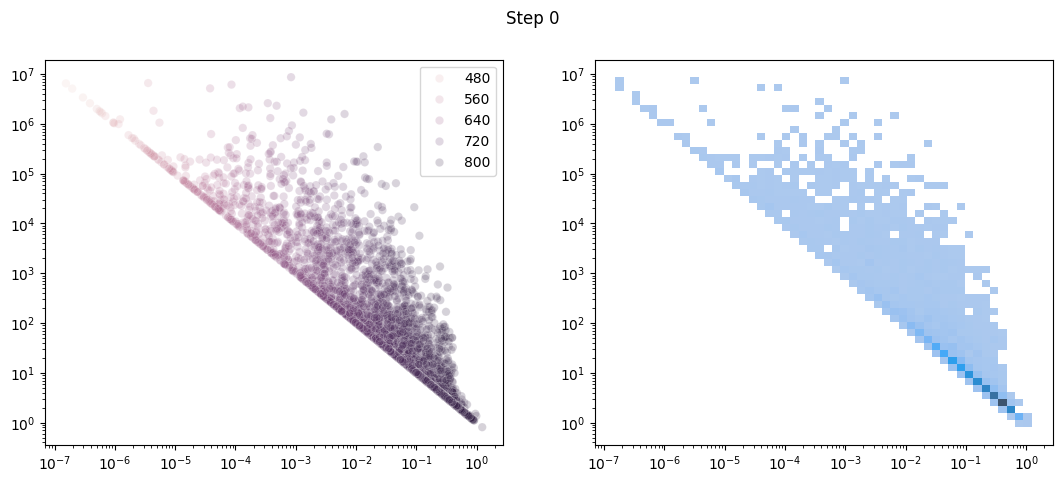

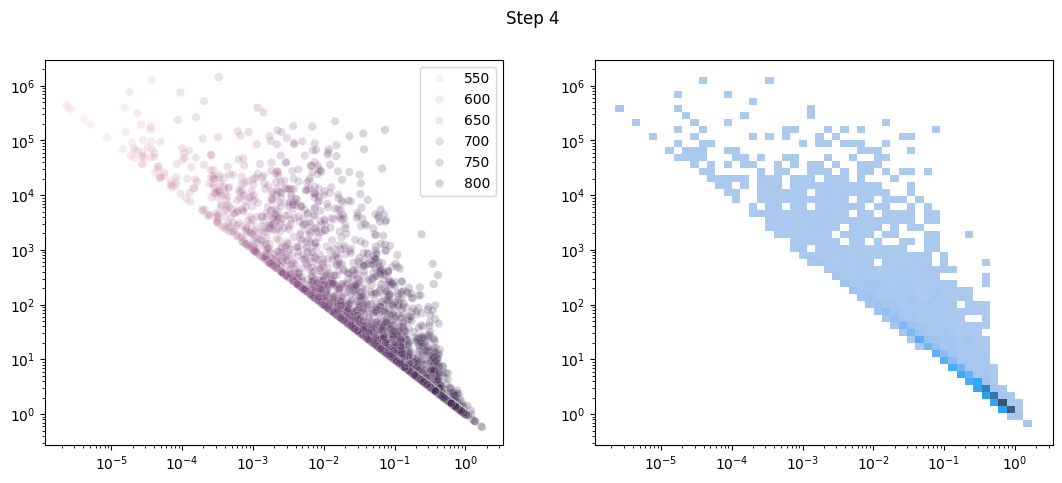

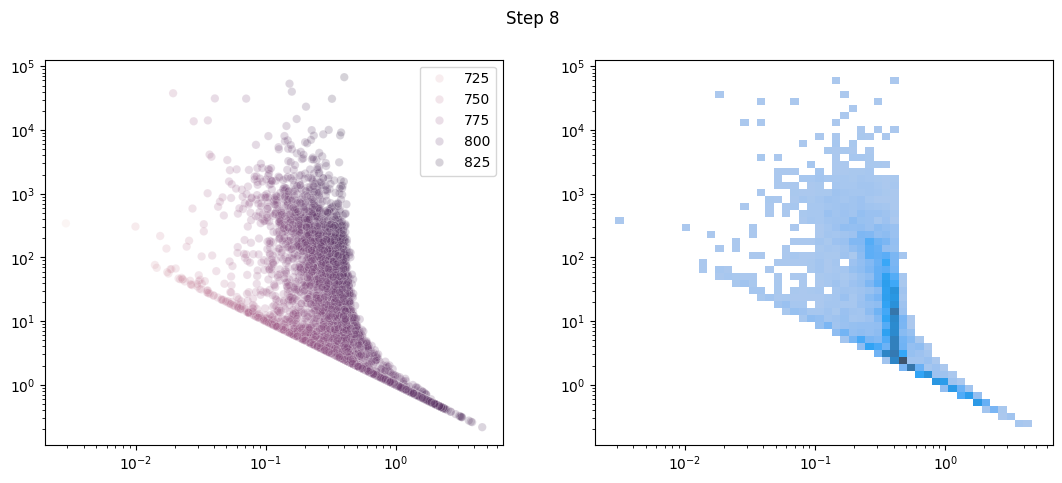

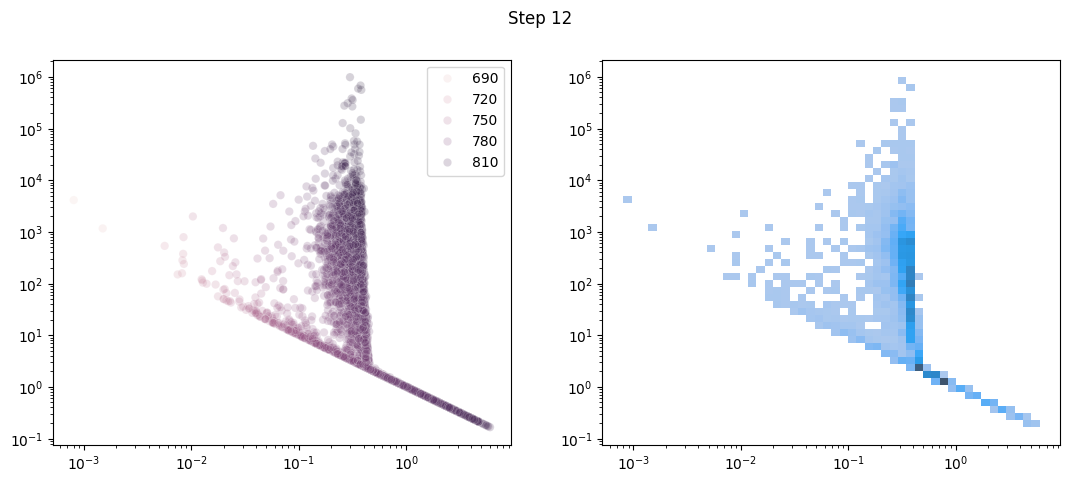

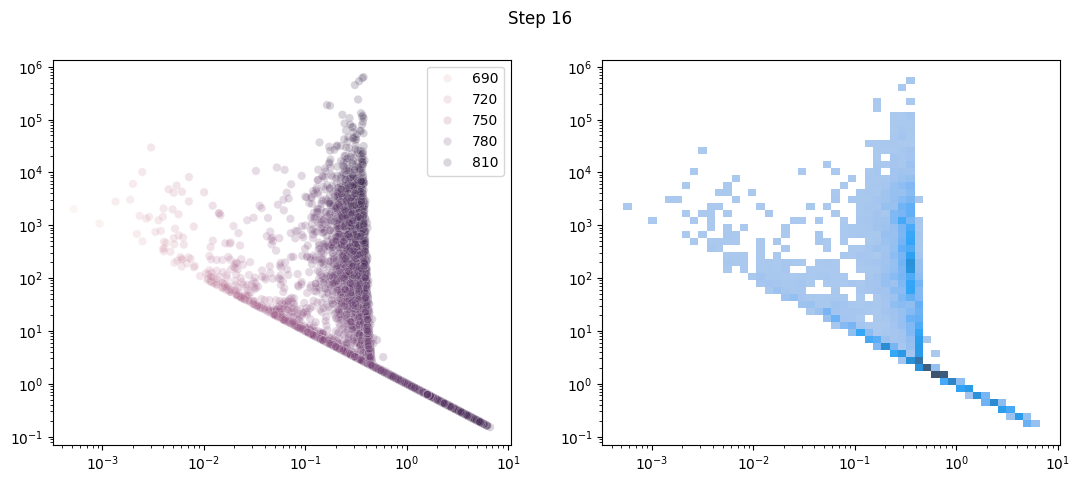

In [7]:
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

curr_en = energies
for step in range(total_steps):

    print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

    curr_eq = jax.vmap(
        partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
    _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

    ys0, ts0, ys1, ts1 = simulate(
        y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
    next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                  use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, 
                                                                  total_samples=total_samples, diversity=diversity)
    print(f'Choosing {len(next_idxs)} next circuits')
    if len(next_idxs) < choose_max:
        print('Not enough circuits chosen, will randomly choose the rest')
        idxs_rnd = choose_next_rnd(choose_max - len(next_idxs), total_samples)
        next_idxs = jnp.concatenate([next_idxs, idxs_rnd])
    
    if np.mod(step, int(total_steps/5)) == 0:
        plt.figure(figsize=(13, 5))
        ax = plt.subplot(1, 2, 1)
        sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
        plt.xscale('log')
        plt.yscale('log')
        ax = plt.subplot(1, 2, 2)
        sns.histplot(x=sensitivity[:, idxs_output].flatten(), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
        plt.suptitle(f'Step {step}')


    # Save results
    all_params_en[step] = curr_en
    all_params_eq[step] = curr_eq
    all_params_rt[step] = curr_rt
    all_is_parent[step][next_idxs] = True
    all_adaptability[step] = adaptability
    all_sensitivity[step] = sensitivity
    all_precision[step] = precision

    # Mutate energies
    next_en = mutate_expand(
        curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
    print(f'Mutated and expanding {len(next_idxs)} into {len(next_en)} next circuits')
    curr_en = next_en

Text(0.5, 0.98, 'Step 19')

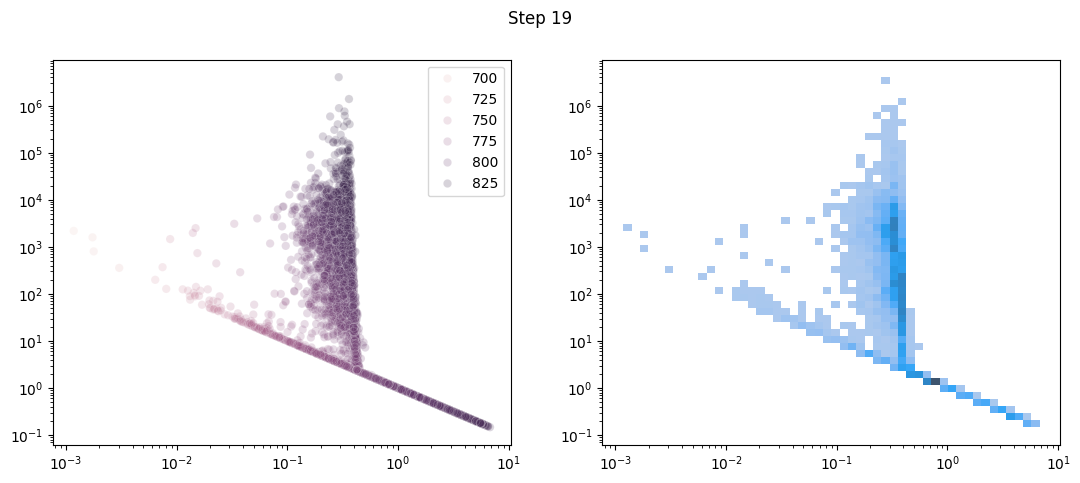

In [8]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(1, 2, 1)
sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1, 2, 2)
sns.histplot(x=sensitivity[:, idxs_output].flatten(), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
plt.suptitle(f'Step {step}')


# Visualise

In [9]:
d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                       'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                       'Precision': all_precision[..., idxs_output].flatten(), 
                       'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                       'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                       'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                       'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output)),
                       'Params energy': [l.tolist() for l in np.repeat(all_params_en.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                       'Params equilibrium constants': [l.tolist() for l in np.repeat(all_params_eq.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                       'Params rates': [l.tolist() for l in np.repeat(all_params_rt.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])]})

In [10]:
d.sort_values(by='Adaptability', ascending=False).to_csv(f'results/23_Monte_Carlo_adaptability_2/23_Monte_Carlo_adaptability_n{total_samples}.csv', index=False)


Maxima - Adaptability: 867.7872314453125, Sensitivity: 14.966212272644043, Precision: inf
Maxima - Adaptability: 861.1702880859375, Sensitivity: 20.058229446411133, Precision: inf


Maxima - Adaptability: 864.5834350585938, Sensitivity: 17.984516143798828, Precision: inf
Maxima - Adaptability: 850.8497314453125, Sensitivity: 11.085976600646973, Precision: inf


Maxima - Adaptability: 852.7890014648438, Sensitivity: 13.708849906921387, Precision: inf
Maxima - Adaptability: 852.204833984375, Sensitivity: 12.691750526428223, Precision: inf


Maxima - Adaptability: 846.44677734375, Sensitivity: 12.300371170043945, Precision: inf
Maxima - Adaptability: 845.2749633789062, Sensitivity: 10.805938720703125, Precision: inf


Maxima - Adaptability: 858.0938720703125, Sensitivity: 10.351592063903809, Precision: inf
Maxima - Adaptability: 844.6891479492188, Sensitivity: 22.643230438232422, Precision: inf


Maxima - Adaptability: 846.2535400390625, Sensitivity: 16.796316146850586, Precision: inf
Maxima - Adaptability: 836.508544921875, Sensitivity: 12.53489875793457, Precision: inf


Maxima - Adaptability: 831.8274536132812, Sensitivity: 12.1864013671875, Precision: inf
Maxima - Adaptability: 831.4669799804688, Sensitivity: 12.616463661193848, Precision: inf


Maxima - Adaptability: 837.1322021484375, Sensitivity: 11.838489532470703, Precision: inf
Maxima - Adaptability: 832.2353515625, Sensitivity: 13.753883361816406, Precision: inf


Maxima - Adaptability: 836.6858520507812, Sensitivity: 13.84631633758545, Precision: inf
Maxima - Adaptability: 832.96875, Sensitivity: 14.094194412231445, Precision: inf


Maxima - Adaptability: 836.2722778320312, Sensitivity: 13.869336128234863, Precision: inf
Maxima - Adaptability: 835.1339721679688, Sensitivity: 13.50564193725586, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

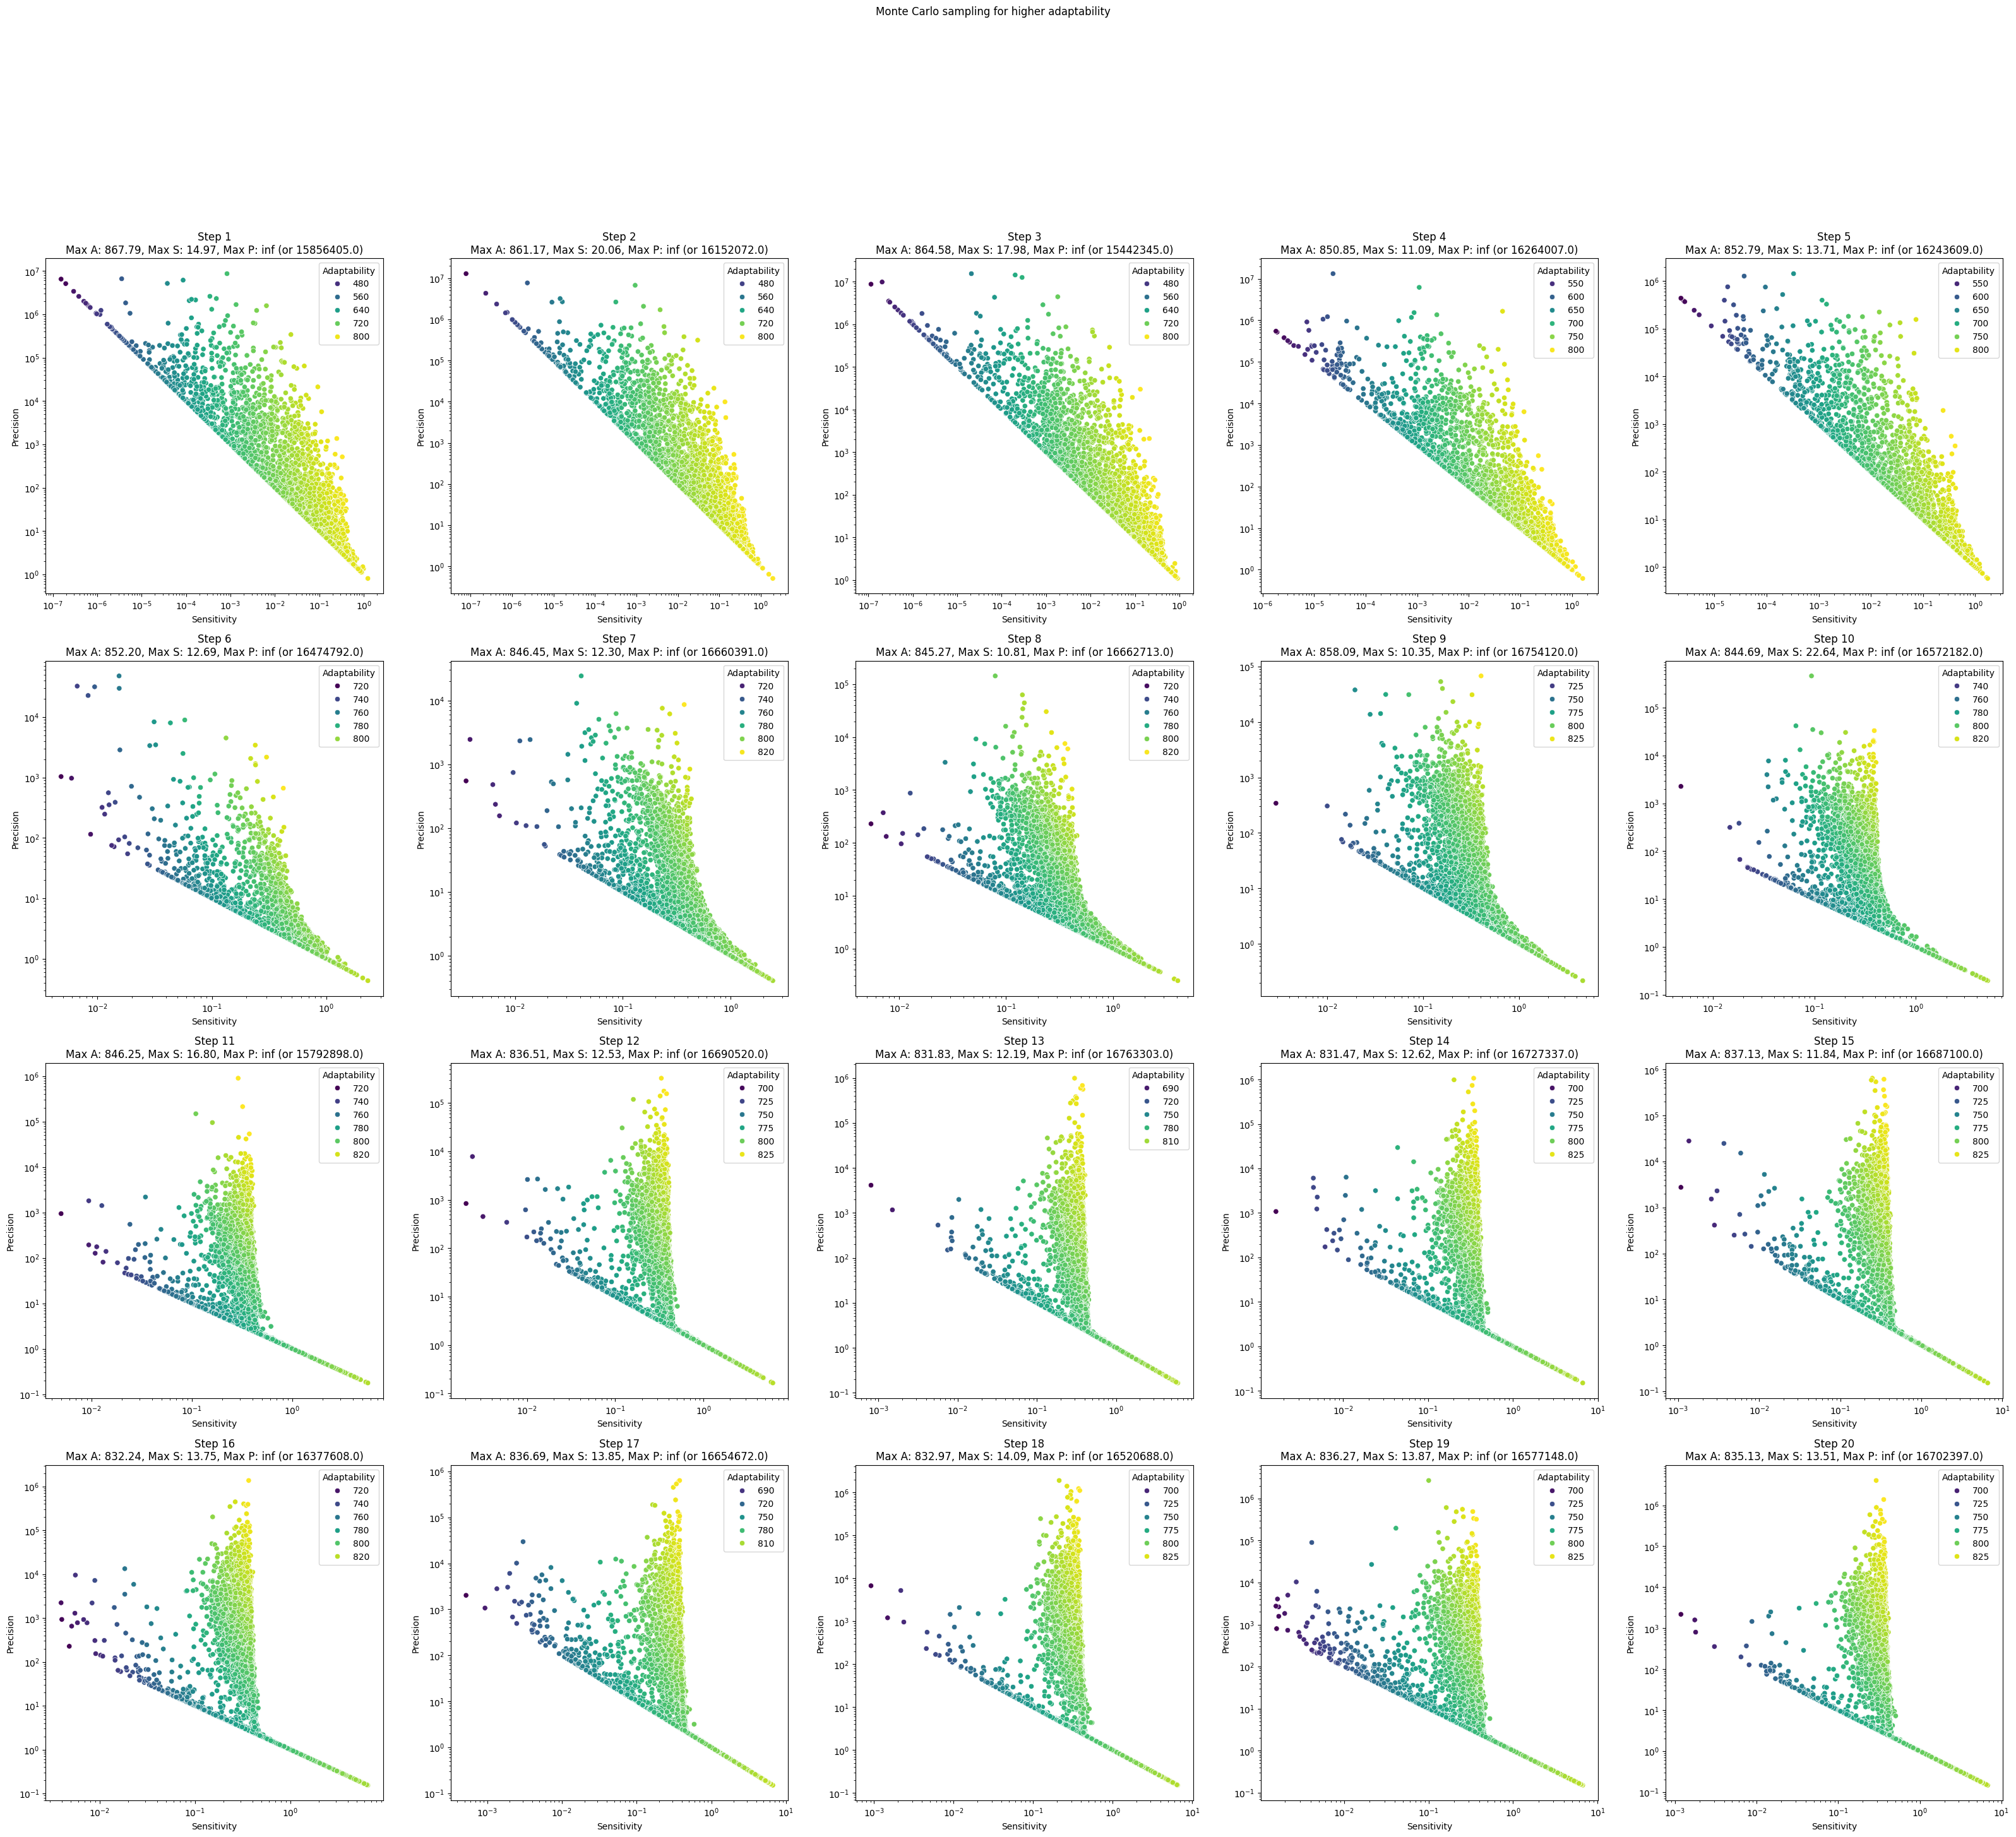

In [11]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {jnp.nanmax(a)}, Sensitivity: {jnp.nanmax(s)}, Precision: {jnp.nanmax(p)}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability', palette='viridis')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {jnp.nanmax(a):.2f}, Max S: {jnp.nanmax(s):.2f}, Max P: {jnp.nanmax(p):.2f} (or {jnp.nanmax(p[p < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

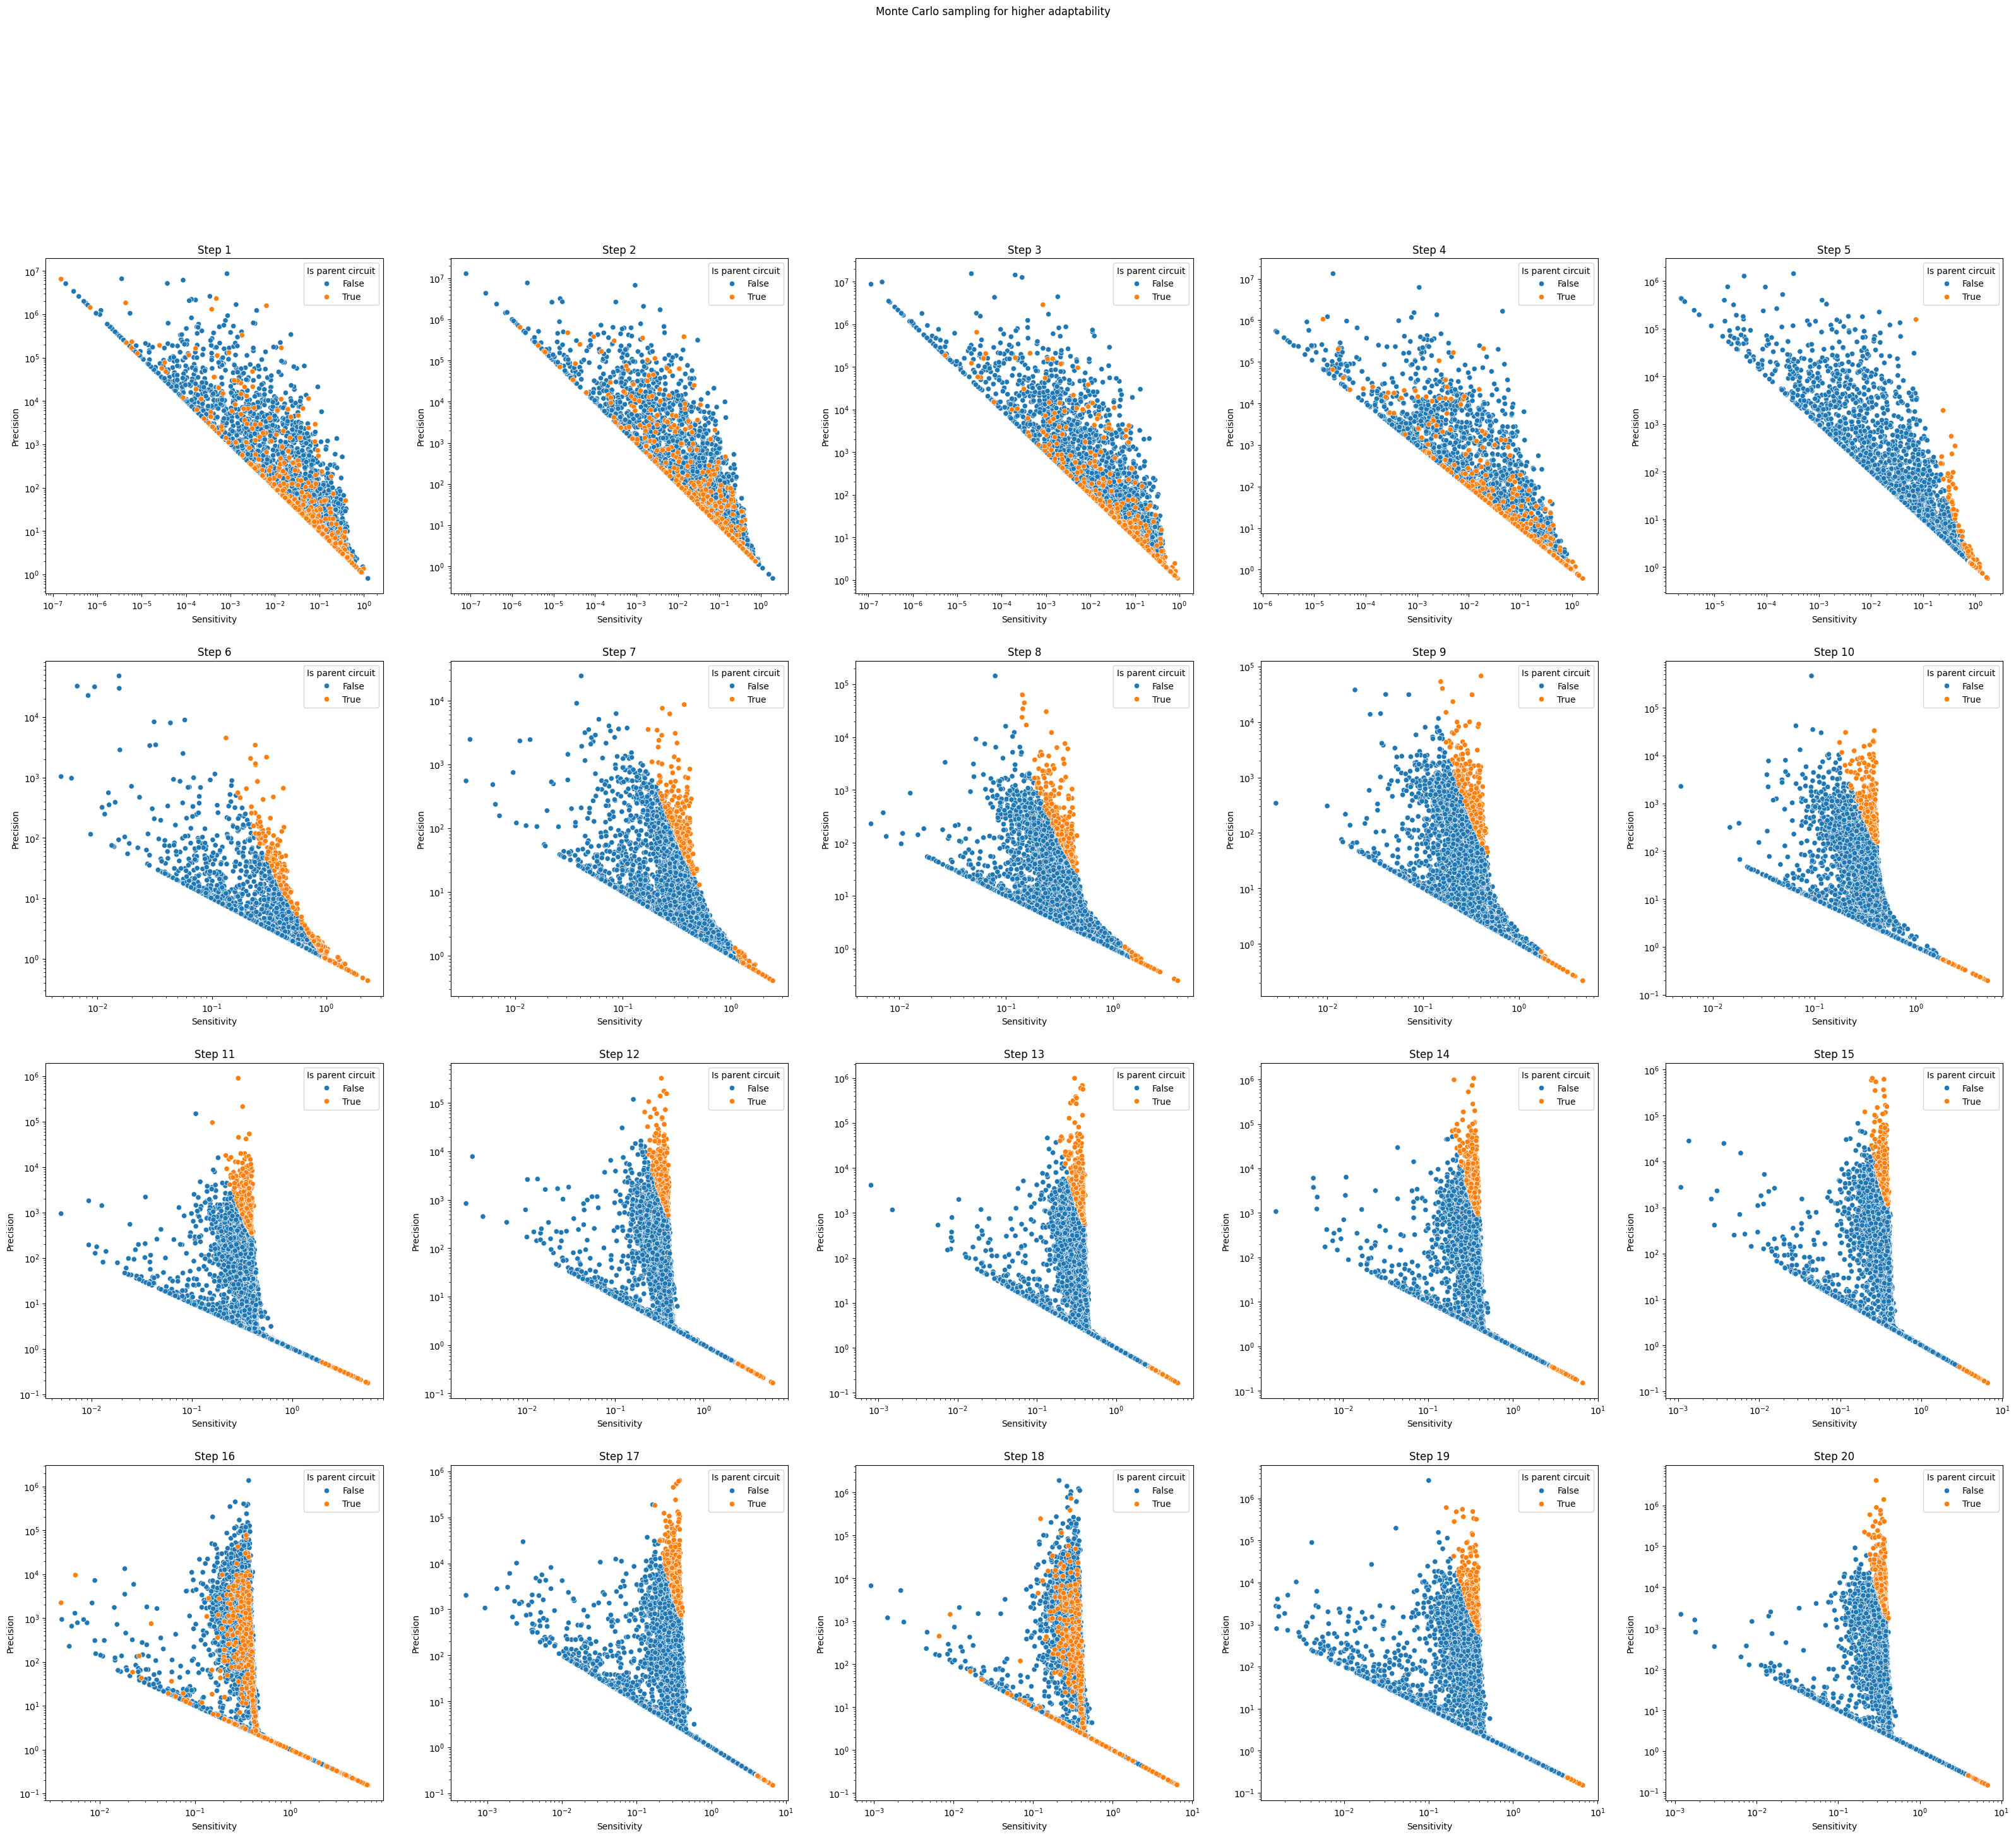

In [12]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')

## Visualise histograms

Text(0.5, 1.0, 'Precision')

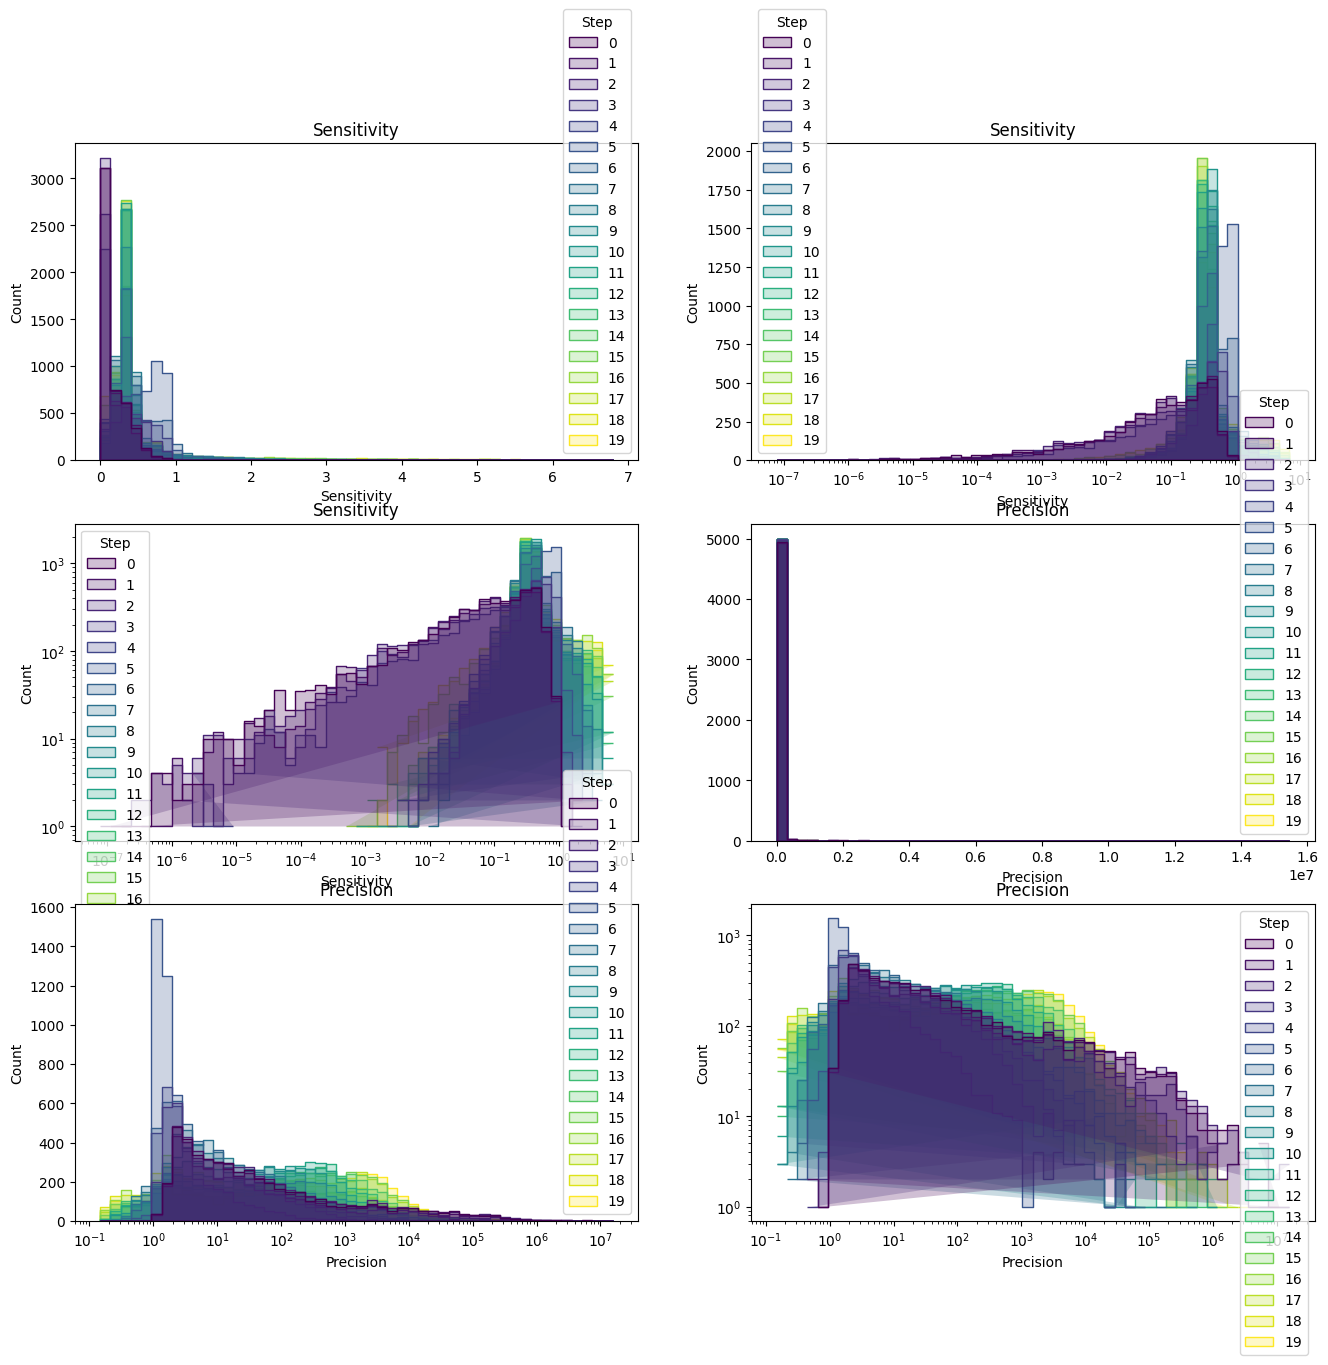

In [13]:
fig = plt.figure(figsize=(8*2, 7*2))
ax = plt.subplot(3, 2, 1)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 2)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 3)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 4)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(3, 2, 5)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(3, 2, 6)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis')
plt.title('Precision')


In [14]:
d.sort_values(by='Adaptability', ascending=False).head(10)

Adaptability  Sensitivity     Precision  Is parent circuit  \
89022    832.968750     0.385321  1.105555e+06              False   
88917    832.437378     0.372425  1.224135e+06              False   
75025    832.235352     0.366005  1.368886e+06              False   
96492    831.988403     0.361070  1.387826e+06               True   
62752    831.827454     0.381413  5.612324e+05               True   
64071    831.802307     0.375272  6.818147e+05               True   
83445    831.740723     0.376194  6.327865e+05               True   
80749    831.134583     0.365686  6.086739e+05               True   
69993    830.776306     0.344814  1.071654e+06               True   
63446    830.617065     0.356744  5.936438e+05               True   

       Circuit idx Species  Step  \
89022         4451   RNA_2    17   
88917         4445   RNA_2    17   
75025         3751   RNA_2    15   
96492         4824   RNA_2    19   
62752         3137   RNA_2    12   
64071         3203   RNA_2    12   
83445         4172   RNA_2    16   
80749         4037   RNA_2    16   
69993         3499   RNA_2    13   
63446         3172   RNA_2    12   

                                           Params energy  \
89022  [-2.490243673324585, -2.3685407638549805, -11....   
88917  [-1.010116457939148, -2.05387020111084, -11.48...   
75025  [-0.9613144993782043, -2.7310869693756104, -11...   
96492  [-1.8473610877990723, -1.2901220321655273, -11...   
62752  [-1.1668790578842163, -3.0316648483276367, -11...   
64071  [-1.4184926748275757, -2.8464436531066895, -11...   
83445  [-1.9835503101348877, -1.5860093832015991, -11...   
80749  [-1.1161882877349854, -1.6135954856872559, -11...   
69993  [-0.9576665163040161, -1.7326295375823975, -10...   
63446  [-1.7788689136505127, -3.0535519123077393, -10...   

                            Params equilibrium constants  \
89022  [1.2297405191930011e-05, 1.1156538676004857e-0...   
88917  [3.76326238438196e-06, 8.673645425005816e-06, ...   
75025  [3.61916841029597e-06, 1.4910451682226267e-05,...   
96492  [7.352804004767677e-06, 4.708128471975215e-06,...   
62752  [4.2660826693463605e-06, 1.896366484288592e-05...   
64071  [5.217335910856491e-06, 1.635196531424299e-05,...   
83445  [8.1991729530273e-06, 5.965543550701113e-06, 0...   
80749  [4.096543761988869e-06, 6.098665835452266e-06,...   
69993  [3.608622364481562e-06, 6.707972715958022e-06,...   
63446  [6.960754944884684e-06, 1.929863174154889e-05,...   

                                            Params rates  
89022  [122.75605773925781, 135.30908203125, 0.074375...  
88917  [401.13623046875, 174.0422821044922, 0.0916659...  
75025  [417.1071472167969, 101.2431411743164, 0.13191...  
96492  [205.3068389892578, 320.6329345703125, 0.09322...  
62752  [353.8564758300781, 79.6038589477539, 0.083325...  
64071  [289.33941650390625, 92.3180160522461, 0.11328...  
83445  [184.11380004882812, 253.050048828125, 0.06237...  
80749  [368.5011291503906, 247.5264129638672, 0.10909...  
69993  [418.32611083984375, 225.04281616210938, 0.139...  
63446  [216.87030029296875, 78.22217559814453, 0.1658...